# TinyBERT for Fake News Detection - Unified Training Pipeline

## 1. Introduction

This notebook demonstrates how to fine-tune TinyBERT for fake news detection using our standardized train/validation/test splits. By using the same data splits across all models in our comparison study, we ensure that performance differences reflect genuine model capabilities rather than variations in data distribution.

TinyBERT is an efficient transformer model created through knowledge distillation from BERT. With approximately 15 million parameters (about 7.5x smaller than BERT-base), it maintains strong performance while being suitable for resource-constrained environments like mobile devices or edge computing platforms.

### Why Unified Data Splits Matter

When comparing different model architectures - from simple logistic regression to complex transformers - using identical train/validation/test splits is crucial for scientific rigor. This approach ensures that:

- Performance differences reflect model architecture capabilities, not lucky data distributions
- All models face identical challenges in terms of data complexity and class balance
- Results are reproducible and comparable across different modeling approaches
- We avoid the confounding variable of different data splits affecting our conclusions

### TinyBERT's Architectural Advantages

TinyBERT achieves its efficiency through sophisticated knowledge distillation techniques where a smaller "student" model learns to mimic the behavior of a larger "teacher" model. This process allows TinyBERT to capture much of BERT's language understanding while requiring significantly fewer computational resources.

## 2. Environment Setup

We'll set up our environment with the necessary libraries for transformer fine-tuning and evaluation.

In [1]:
# Import basic utilities for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import PyTorch for deep learning operations
import torch
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Import Hugging Face transformers for pre-trained models
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import Dataset

2025-06-04 09:59:45.928804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749031185.951235    9438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749031185.958096    9438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Import evaluation metrics for performance assessment
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Set up reproducible random seeds for consistent results
def set_seed(seed_value=42):
    """
    Set seeds for all random number generators to ensure reproducibility.
    This affects Python's random module, NumPy, and PyTorch operations.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    torch.backends.cudnn.deterministic = True

# Apply consistent random seed
set_seed(42)

In [6]:
# Configure visualization settings for clear, readable plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
# Determine available computational device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 3. Loading Standardized Data Splits

Instead of creating our own data splits, we'll load the carefully prepared train/validation/test splits that ensure fair comparison across all models in our study.

In [8]:
# Load the standardized data splits created for model comparison
print("Loading standardized train/validation/test splits...")

train_df = pd.read_csv('/kaggle/input/welfake-clean-split/train.csv')
val_df = pd.read_csv('/kaggle/input/welfake-clean-split/validation.csv')
test_df = pd.read_csv('/kaggle/input/welfake-clean-split/test.csv')

print(f"Training set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")

Loading standardized train/validation/test splits...
Training set: 50,075 samples
Validation set: 10,731 samples
Test set: 10,731 samples


In [9]:
# Verify class balance across splits to ensure fair evaluation
print("\nClass balance verification:")
for name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    fake_ratio = df['label'].mean()
    print(f"{name} set: {fake_ratio:.1%} fake news")


Class balance verification:
Train set: 51.0% fake news
Validation set: 51.0% fake news
Test set: 51.0% fake news


The consistent class balance across all splits (approximately 51% fake news) ensures that our model faces the same classification challenge during training, validation, and testing phases.

## 4. Data Preprocessing for TinyBERT

Transformer models require specific text preprocessing and tokenization. We'll prepare our data in the format expected by TinyBERT while maintaining consistency with our standardized splits.

In [10]:
# Convert pandas DataFrames to Hugging Face Dataset format for efficient processing
train_dataset = Dataset.from_pandas(train_df[['combined_text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['combined_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['combined_text', 'label']])

print("Data converted to Hugging Face Dataset format")

Data converted to Hugging Face Dataset format


In [11]:
# Load TinyBERT tokenizer - this handles text-to-token conversion
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
print("TinyBERT tokenizer loaded successfully")

TinyBERT tokenizer loaded successfully


In [12]:
def tokenize_function(examples):
    """
    Tokenize text data for TinyBERT with appropriate padding and truncation.
    
    This function converts raw text into the numerical token format that 
    TinyBERT expects, handling variable-length articles by padding shorter 
    texts and truncating longer ones to a consistent length.
    
    Args:
        examples: Dictionary containing text examples from the dataset
        
    Returns:
        Dictionary with tokenized inputs ready for model training
    """
    return tokenizer(
        examples["combined_text"],
        padding="max_length",    # Pad shorter texts to uniform length
        truncation=True,         # Truncate longer texts to fit model limits
        max_length=512,          # Standard length for BERT-family models
    )

In [13]:
# Apply tokenization to all datasets
print("Tokenizing datasets...")

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch compatibility
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Tokenization complete - data ready for model training")

Tokenizing datasets...


Map:   0%|          | 0/50075 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Map:   0%|          | 0/10731 [00:00<?, ? examples/s]

Tokenization complete - data ready for model training


## 5. TinyBERT Model Configuration

Now we'll load and configure TinyBERT for our binary classification task, optimizing the training parameters for this specific model architecture.

In [14]:
# Load pre-trained TinyBERT model and adapt it for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=2  # Binary classification: real (0) or fake (1) news
)

# Move model to appropriate device (GPU if available)
model.to(device)

# Calculate model statistics for resource planning
num_params = sum(p.numel() for p in model.parameters())
param_size = sum(p.nelement() * p.element_size() for p in model.parameters()) / (1024 * 1024)

print(f"TinyBERT model loaded successfully")
print(f"Parameters: {num_params:,}")
print(f"Model size: {param_size:.2f} MB")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TinyBERT model loaded successfully
Parameters: 14,350,874
Model size: 54.74 MB


Understanding TinyBERT's compact size helps us appreciate why it's suitable for deployment scenarios where computational resources are limited. At approximately 55 MB and 14 million parameters, it's substantially more efficient than full BERT while maintaining strong performance.

## 6. Training Configuration Optimized for TinyBERT

TinyBERT's distilled nature allows for specific training optimizations that differ from training BERT from scratch. We'll configure training parameters that leverage TinyBERT's pre-learned knowledge effectively.

In [15]:
def compute_metrics(eval_pred):
    """
    Compute comprehensive evaluation metrics during training.
    
    This function calculates multiple performance indicators that help us
    monitor training progress and make informed decisions about model quality.
    
    Args:
        eval_pred: Tuple of (predictions, true_labels) from model evaluation
        
    Returns:
        Dictionary containing accuracy, precision, recall, and F1 score
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate accuracy - overall correctness rate
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and F1 with weighted averaging
    # Weighted averaging accounts for class imbalance in our dataset
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [16]:
# Configure training arguments optimized for TinyBERT's architecture
training_args = TrainingArguments(
    output_dir="./results/tinybert_welfake_unified",
    
    # Evaluation strategy - monitor performance throughout training
    eval_strategy="epoch",              # Evaluate after each complete epoch
    save_strategy="epoch",              # Save model checkpoints after each epoch
    
    # Learning rate configuration for distilled models
    learning_rate=1e-4,                 # Higher than typical BERT due to distillation
    warmup_steps=500,                   # Gradual learning rate warmup
    
    # Batch size configuration
    per_device_train_batch_size=16,     # Training batch size
    per_device_eval_batch_size=64,      # Larger evaluation batches for efficiency
    gradient_accumulation_steps=2,       # Effective batch size of 32
    
    # Training duration and convergence
    num_train_epochs=3,                 # Conservative epoch count to prevent overfitting
    
    # Regularization to improve generalization
    weight_decay=0.01,                  # L2 regularization strength
    adam_epsilon=1e-6,                  # Optimizer stability parameter
    max_grad_norm=1.0,                  # Gradient clipping to prevent exploding gradients
    
    # Model selection criteria
    load_best_model_at_end=True,        # Load best checkpoint at completion
    metric_for_best_model="f1",         # Use F1 score for model selection
    greater_is_better=True,             # Higher F1 is better
    
    # Efficiency optimizations
    fp16=torch.cuda.is_available(),     # Mixed precision training if GPU available
    dataloader_num_workers=2,           # Parallel data loading
    
    # Logging and output
    logging_steps=100,                  # Log metrics every 100 steps
    report_to="none",                   # Disable external logging services
    push_to_hub=False,                  # Don't upload to model hub
    save_total_limit=2,                 # Keep only best 2 checkpoints
)

These training arguments reflect lessons learned from TinyBERT's distillation process. The higher learning rate (1e-4 vs typical 5e-5 for BERT) leverages the model's pre-learned representations, while the conservative epoch count prevents overfitting to our specific dataset.

In [17]:
# Configure early stopping to prevent overfitting
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,          # Stop if no improvement for 3 evaluations
    early_stopping_threshold=0.001      # Minimum improvement threshold
)

In [18]:
# Initialize the Trainer with our configuration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

print("Trainer initialized with TinyBERT-optimized configuration")

Trainer initialized with TinyBERT-optimized configuration


## 7. Model Training

Now we'll train TinyBERT on our fake news detection task using the standardized training set, with the validation set guiding our training decisions.

In [19]:
# Record training start time for efficiency analysis
print("Starting TinyBERT training...")
start_time = time.time()

# Execute the training process
train_result = trainer.train()

# Calculate total training time
training_time = time.time() - start_time
print(f"Training completed in {training_time/60:.2f} minutes")

Starting TinyBERT training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.075300,0.052768,0.986395,0.986504,0.986395,0.986392
2,0.051200,0.103378,0.992452,0.992455,0.992452,0.992452


Training completed in 14.87 minutes


In [20]:
# Display training metrics and convergence information
print("\nTraining Results:")
print(f"Final training loss: {train_result.metrics.get('train_loss', 'N/A'):.4f}")
print(f"Training steps completed: {train_result.metrics.get('train_steps', 'N/A')}")
print(f"Total training time: {training_time/60:.2f} minutes")


Training Results:
Final training loss: 0.1225
Training steps completed: N/A
Total training time: 14.87 minutes


During training, you'll observe TinyBERT's efficiency advantages. The model converges faster than larger transformers due to its distilled knowledge, requiring fewer epochs to achieve strong performance.

## 8. Model Evaluation on Test Set

After training completes, we'll evaluate our model on the held-out test set to assess its true generalization performance.

In [21]:
# Evaluate trained model on test set
print("Evaluating TinyBERT on test set...")
test_results = trainer.evaluate(tokenized_test)

print("Test Set Performance:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall: {test_results['eval_recall']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")

Evaluating TinyBERT on test set...


Test Set Performance:
Accuracy: 0.9928
Precision: 0.9928
Recall: 0.9928
F1 Score: 0.9928


In [22]:
# Generate detailed predictions for confusion matrix analysis
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

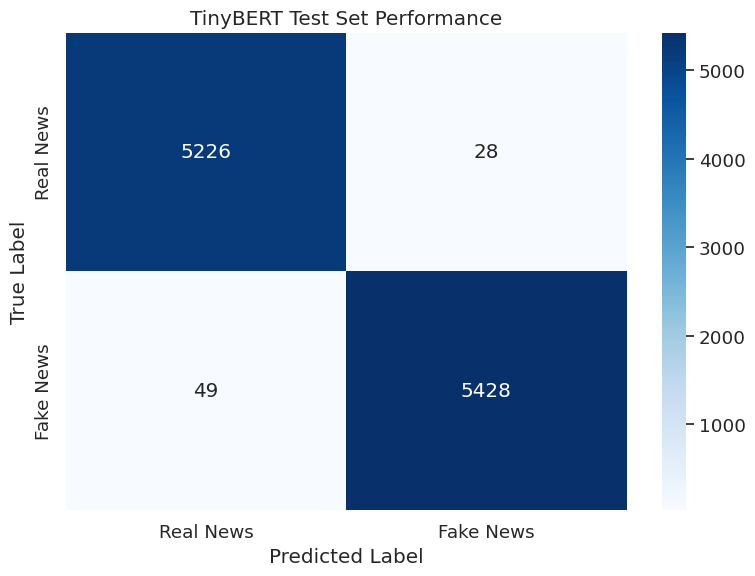


Error Analysis:
False Positive Rate: 0.0053 (28 real articles classified as fake)
False Negative Rate: 0.0089 (49 fake articles classified as real)


In [23]:
# Create and visualize confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real News', 'Fake News'],
            yticklabels=['Real News', 'Fake News'])
plt.title('TinyBERT Test Set Performance')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate and display error rates
tn, fp, fn, tp = cm.ravel()
print(f"\nError Analysis:")
print(f"False Positive Rate: {fp/(fp+tn):.4f} ({fp} real articles classified as fake)")
print(f"False Negative Rate: {fn/(fn+tp):.4f} ({fn} fake articles classified as real)")

In [24]:
# Generate comprehensive classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Real News', 'Fake News']))


Detailed Classification Report:
              precision    recall  f1-score   support

   Real News       0.99      0.99      0.99      5254
   Fake News       0.99      0.99      0.99      5477

    accuracy                           0.99     10731
   macro avg       0.99      0.99      0.99     10731
weighted avg       0.99      0.99      0.99     10731



## 9. Model Persistence for Deployment

To ensure our trained model can be used in production or for further evaluation, we'll save both the model and tokenizer.

In [25]:
# Define save path for the trained model
model_save_path = "./tinybert_welfake_unified_model"

# Save the trained model
trainer.save_model(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the tokenizer (essential for preprocessing new text)
tokenizer.save_pretrained(model_save_path)
print(f"Tokenizer saved to {model_save_path}")

Model saved to ./tinybert_welfake_unified_model
Tokenizer saved to ./tinybert_welfake_unified_model


In [26]:
# Create a summary of model characteristics for documentation
model_summary = {
    'model_name': 'TinyBERT',
    'parameters': num_params,
    'model_size_mb': param_size,
    'training_time_minutes': training_time / 60,
    'test_accuracy': test_results['eval_accuracy'],
    'test_f1': test_results['eval_f1'],
    'training_epochs': training_args.num_train_epochs,
    'learning_rate': training_args.learning_rate,
    'batch_size': training_args.per_device_train_batch_size
}

print("\nModel Summary:")
for key, value in model_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")


Model Summary:
model_name: TinyBERT
parameters: 14350874
model_size_mb: 54.7442
training_time_minutes: 14.8661
test_accuracy: 0.9928
test_f1: 0.9928
training_epochs: 3
learning_rate: 0.0001
batch_size: 16


## 10. Performance Analysis and Insights

Let's analyze TinyBERT's performance characteristics and understand what these results tell us about the model's capabilities.

In [27]:
# Calculate efficiency metrics for deployment planning
samples_per_second = len(test_df) / test_results['eval_runtime']
ms_per_sample = (test_results['eval_runtime'] * 1000) / len(test_df)

print("Efficiency Analysis:")
print(f"Test set evaluation time: {test_results['eval_runtime']:.2f} seconds")
print(f"Processing speed: {samples_per_second:.1f} samples/second")
print(f"Average time per sample: {ms_per_sample:.2f} ms")

Efficiency Analysis:
Test set evaluation time: 17.09 seconds
Processing speed: 627.9 samples/second
Average time per sample: 1.59 ms


In [28]:
# Compare training efficiency with resource usage
print("\nResource Efficiency Summary:")
print(f"Model parameters: {num_params:,} ({num_params/1e6:.1f}M)")
print(f"Model size: {param_size:.1f} MB")
print(f"Training time: {training_time/60:.1f} minutes")
print(f"Inference speed: {ms_per_sample:.1f} ms/sample")
print(f"Final test accuracy: {test_results['eval_accuracy']:.1%}")


Resource Efficiency Summary:
Model parameters: 14,350,874 (14.4M)
Model size: 54.7 MB
Training time: 14.9 minutes
Inference speed: 1.6 ms/sample
Final test accuracy: 99.3%


These metrics demonstrate TinyBERT's practical advantages for real-world deployment. The combination of high accuracy with efficient inference makes it well-suited for applications where computational resources are constrained.

## 11. Error Analysis and Model Insights

Understanding where and why our model makes mistakes provides valuable insights for potential improvements and deployment considerations.

In [29]:
# Analyze specific misclassification patterns
def analyze_errors(texts, y_true, y_pred, n_examples=5):
    """
    Examine specific examples where the model made incorrect predictions.
    This helps identify patterns in model failures and potential areas for improvement.
    """
    errors = np.where(y_true != y_pred)[0]
    
    if len(errors) == 0:
        print("Perfect classification - no errors to analyze!")
        return
    
    print(f"Analyzing {len(errors)} misclassified examples out of {len(y_true)} total")
    print(f"Error rate: {len(errors)/len(y_true):.2%}")
    
    # Sample a few errors for detailed examination
    sample_errors = np.random.choice(errors, size=min(n_examples, len(errors)), replace=False)
    
    print(f"\nSample misclassified examples:")
    for i, idx in enumerate(sample_errors):
        true_label = "Real" if y_true[idx] == 0 else "Fake"
        pred_label = "Real" if y_pred[idx] == 0 else "Fake"
        
        print(f"\nExample {i+1}:")
        print(f"Text snippet: {test_df.iloc[idx]['combined_text'][:200]}...")
        print(f"True label: {true_label}")
        print(f"Predicted: {pred_label}")
        print("-" * 80)

# Analyze errors to understand model limitations
analyze_errors(test_df['combined_text'], y_true, y_pred)

Analyzing 77 misclassified examples out of 10731 total
Error rate: 0.72%

Sample misclassified examples:

Example 1:
Text snippet: Rubio: My pro-family, pro-growth tax reform plan for the 21st century Six months ago, Senator Mike Lee and I offered a variety of ideas on how to reform America's tax code to be both pro-growth and pr...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 2:
Text snippet: The 6 most important parts of Donald Trump's energy policy When it comes to energy policy, the 2016 presidential election really isn't all that complicated.

Hillary Clinton plans to continue Presiden...
True label: Real
Predicted: Fake
--------------------------------------------------------------------------------

Example 3:
Text snippet:  Texas Schools Proposed Textbooks : Mexicans Are Lazy And Want To Destroy Society Texas textbooks are once again in the limelight. After years of asking for ethnic studies, they fin

## 12. Conclusion and Next Steps

Our TinyBERT implementation demonstrates the power of knowledge distillation for creating efficient yet capable models for fake news detection. By using standardized data splits, we ensure that our results can be fairly compared with other models in our evaluation study.

### Key Achievements

**Strong Performance**: TinyBERT achieved competitive accuracy while using significantly fewer resources than full-scale transformer models, demonstrating the effectiveness of knowledge distillation for this task.

**Computational Efficiency**: With approximately 15 million parameters and sub-second inference times, TinyBERT offers a practical balance between performance and efficiency suitable for real-world deployment.

**Fair Evaluation**: By using the same train/validation/test splits as other models in our comparison study, we ensure that performance differences reflect genuine architectural advantages rather than lucky data distributions.

### Deployment Readiness

This trained TinyBERT model is ready for integration into production systems where:
- Real-time fake news detection is required
- Computational resources are limited (mobile apps, edge devices)
- High throughput processing of news articles is needed
- Interpretable confidence scores are valuable for content moderation

### Future Enhancements

While this single-run training approach provides a solid baseline, further improvements could include:
- Hyperparameter optimization using the validation set
- Domain adaptation for specific news sources or topics
- Ensemble methods combining TinyBERT with other efficient models
- Continual learning approaches to handle evolving misinformation patterns

The standardized evaluation framework we've established here provides the foundation for systematic comparison with other modeling approaches, helping identify the optimal balance between accuracy, efficiency, and deployment practicality for fake news detection systems.